# Text Analytics
Question 2:

Discuss the concept and application of Text Analytics (eg text categorisation, topic modelling and document summarisation) using machine learning modelling by providing a real-world data set of social media posts. 

Apply appropriate text analytics tools to the chosen dataset. 

In [355]:
# !pip install gensim
# !pip install pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [356]:
#Import the libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import json
import nltk
import collections
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim import corpora, models

# Download the 'punkt' package
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mecunnin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## EDA Load and look at data

In [357]:
# Load data set
df = pd.read_json('tweets.json', lines=True)

In [358]:
#looking at the first 20 rows of the data set
print(df.head(20))

     keyword  likes                                              tweet
0   COVID-19      1  The headline kinda makes it sound like the AP ...
1   COVID-19      0  ATLANTIC CITY — The city's Police Athletic Lea...
2   COVID-19      0  I feel like Diana's line she draws is if his s...
3   COVID-19      1  COVID-19 was the single most fatal communicabl...
4   COVID-19      0  Studies: Dogs can detect COVID-19 with greater...
5   COVID-19      1  Now you're putting a lot of different things o...
6   COVID-19      0  Wow,how can you forget the KEMSA scandals whic...
7   COVID-19      0  The hardest thing to change are people's minds...
8   COVID-19      0                                    unroll #COVID19
9   COVID-19      0  Hidden in plain sight, the truth about Covid-1...
10  COVID-19      0                                    unroll #COVID19
11  COVID-19     23  DO NO HARM - OR 'SAVING' THEMSELVES?On March 1...
12  COVID-19     10  Well dogs reportedly can sniff out cancer an a...
13  CO

In [359]:
# Check for missing values
print(df.isnull().sum())

keyword    0
likes      0
tweet      0
dtype: int64


In [360]:
print(df.columns)

Index(['keyword', 'likes', 'tweet'], dtype='object')


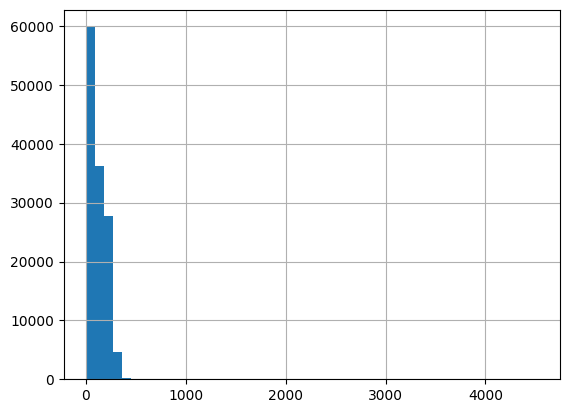

In [361]:
#Now lets analyze the tweet length
df['tweet_length'] = df['tweet'].apply(len)
df['tweet_length'].hist(bins=50)
plt.show()


### Firstly let me print/review all the unique words in 'tweet' column

 Ref https://learn.microsoft.com/en-us/azure/architecture/data-guide/technology-choices/natural-language-processing
I create a token DF for all the tweets, and split all the individual words where there are spaces.
and put them in a new colum called tokens



In [362]:
# Tokenize the tweets
df['tokens'] = df['tweet'].str.split()

# Flatten the list of words. (simngle list of words)
all_words = [word for tokens in df['tokens'] for word in tokens]

# convert all words to unique words
unique_words = set(all_words)

# Print unique words
for word in unique_words:
    print(word)

97,
alcoholic?
Asthma
UTM
🤣😂
lit.
refused.
Morissette
Backgrid
6:44
revisions"Wonderful
amount.
Stalin-Era
0.125
29%
#iPadrepair
work?Elon
Background:
𝖕𝖗𝖔𝖙𝖊𝖈𝖙𝖎𝖔𝖓.
#ClearTheAir
✊🏿🚩
February.I
May.John
KFC.
wnba,
Thomas!!!
#LuxuryTraveller
#BlockchainGaming
opsec,
insulting.
Horse.
Platinum
FONT!
#WNXMUSDT
Horrible,
WASL
🏖️
(VIDEO)
chocolate
Twitter.#Shadowban
Barns
Scores😠TELLS
End:
avoidedNo
Read
Our
#pso
tree.
sing,
TwitterIND
#army
dots…..
careIve
ordinal.
earlier.They
Reveal
Vary)
rocket.
PredictionGame
TE.
43,
episodes?
(see
2.09M
Florida(sorry
Smith?😉
poksy
Kara
Also,
Novena!
PARTY!!!🐸
MOUTH."
gay”?Is
hypothetically.#JohnnyDeppWon
Gala!
practioner?
cata.
me:
1.7
bopped
moderation,
𝐔𝐒
Pens
rep)Premier:
NovoNordisk)
su…
attends!
#Embarrassing
CST...
different,Smith
oan
uni
#suleimanosman
full-color
$359.99][Gamestop]
connection.
wld
Bta
6.8
mphTemperature:
8MM
$1.21click&gt;&gt;#amazon
?AND
🥤
triple
picked
fiction;
Cup.#FIFAWorldCup
ZOOM,WE
sterling162
maneuvering
Remco
#IFPinofranq

### Preprocessing the data
to make it easy to analise later I need to standardise the 'tweet' column,= with preprocessing. I wil convert all the charaters to lower case and remove all special characters.

All this ensure only letters remain in the 'tweet' column.

In [363]:
# Preprocessing: Lowercasing and removing special characters from tweets
df['Processed Tweet'] = df['tweet'].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)

### Test Categoirsation

CreateWord Cloud to observe most frequent words 

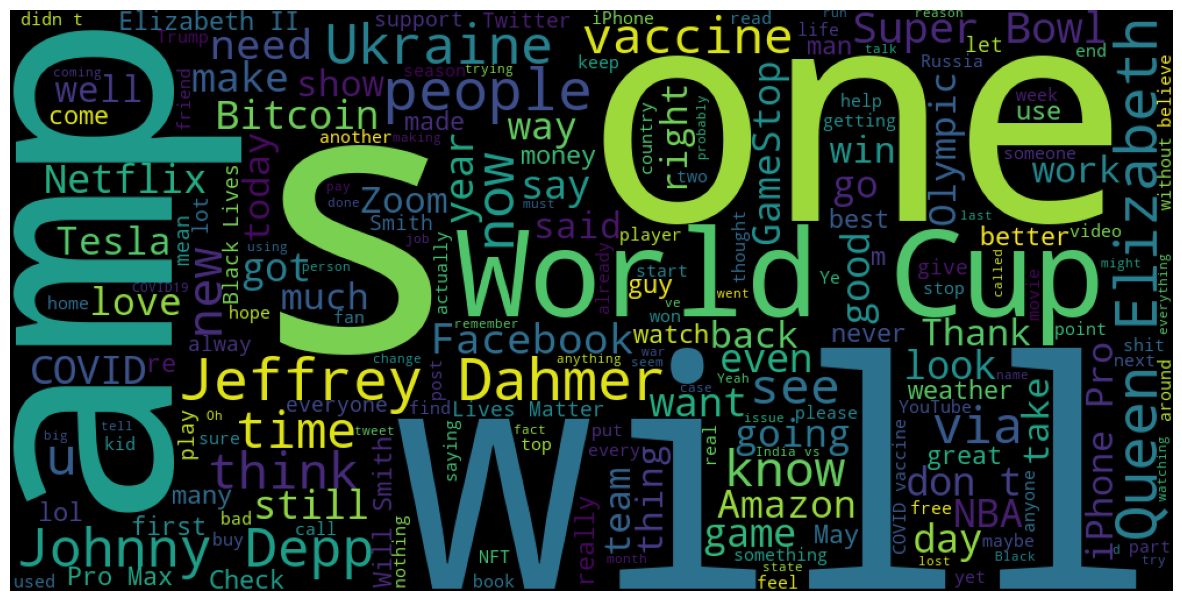

In [364]:
# Word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(df['tweet']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [365]:
# Count the frequency of each word
word_count = collections.Counter(all_words)

# Print the 10 most common words
print(word_count.most_common(20))

[('the', 89199), ('to', 58402), ('and', 47020), ('a', 46303), ('of', 38527), ('in', 34104), ('is', 30836), ('I', 28112), ('for', 27757), ('on', 23043), ('you', 19788), ('that', 18715), ('with', 15081), ('it', 14393), ('be', 13620), ('was', 12950), ('this', 12548), ('are', 12198), ('have', 11735), ('at', 11252)]


I notice alot of common words like ('to', 58402), ('and', 47020), ('a', 46303), ('of', 38527), ('in', 34104) etc, I will need to removde these using (Natural Language Toolkit)

In [366]:
# Download the 'stopwords' package
nltk.download('stopwords')

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Add 'like', 'vs', 'im', 'u', 'g', 'fs', 'f' to the list of stop words as they are common words in the tweets
stop_words.update('like', 'vs', 'im', 'u', 'g', 'fs', 'f')

# Tokenize the tweets and remove stop words
df['tokens'] = df['Processed Tweet'].str.split().apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Flatten the list of words
all_words = [word for tokens in df['tokens'] for word in tokens]

# Count the frequency of each word
word_count = collections.Counter(all_words)

# Print the 10 most common words
print(word_count.most_common(10))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mecunnin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('like', 9542), ('world', 7457), ('covid', 6666), ('iphone', 6636), ('one', 6453), ('amp', 6223), ('get', 5999), ('people', 5886), ('dont', 5837), ('cup', 5607)]


In [367]:
# Count the frequency of each word
word_count = collections.Counter(all_words)

# Get the 20 most common words
most_common_words = word_count.most_common(20)

# Convert the list of tuples into a DataFrame
df_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# Print the DataFrame
print(df_common_words)

        Word  Count
0       like   9542
1      world   7457
2      covid   6666
3     iphone   6636
4        one   6453
5        amp   6223
6        get   5999
7     people   5886
8       dont   5837
9        cup   5607
10     queen   5534
11       via   5224
12   ukraine   5146
13        im   5056
14   jeffrey   4994
15    dahmer   4882
16  facebook   4690
17   weather   4651
18     would   4607
19   bitcoin   4570


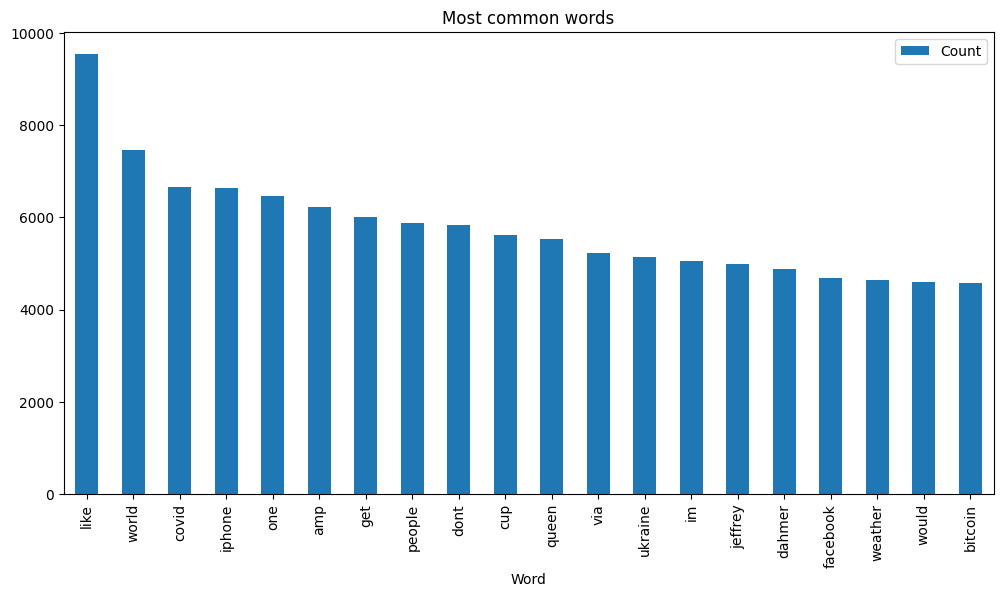

In [368]:
 # Plot of the most common words#
df_common_words.plot(kind='bar', x='Word', y='Count', figsize=(12, 6))
plt.title('Most common words')
plt.show()

Second wordcloud to show the words more Pronunced in the visual

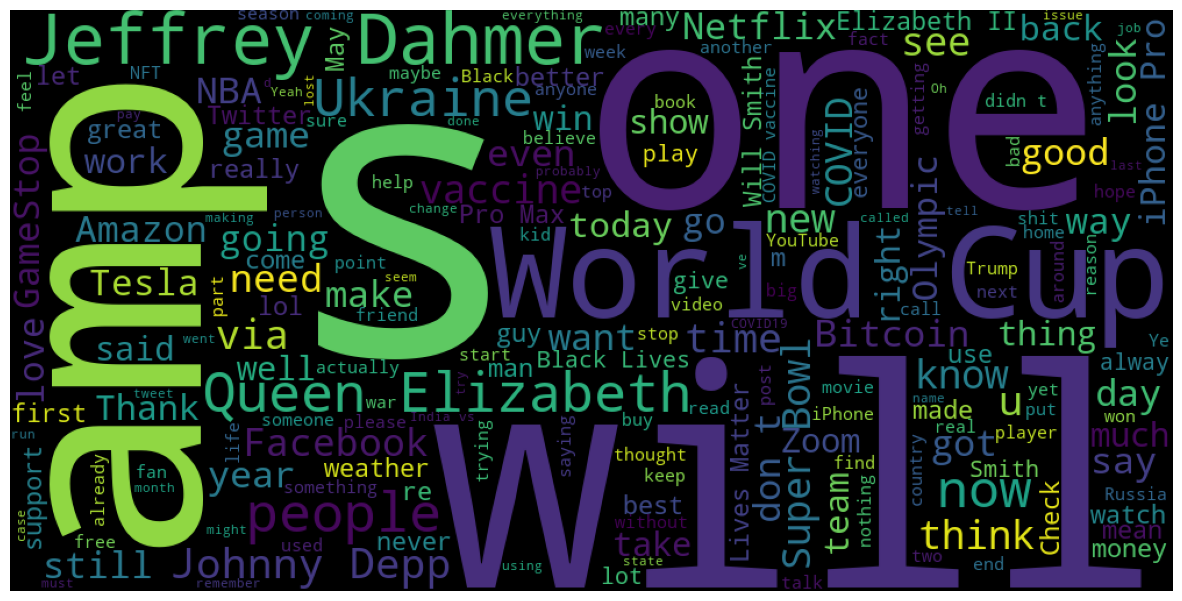

In [369]:
# Word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(df['tweet']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [370]:
# Display the first few rows of the dataframe with the new category
print(df.head(10))

    keyword  likes                                              tweet  \
0  COVID-19      1  The headline kinda makes it sound like the AP ...   
1  COVID-19      0  ATLANTIC CITY — The city's Police Athletic Lea...   
2  COVID-19      0  I feel like Diana's line she draws is if his s...   
3  COVID-19      1  COVID-19 was the single most fatal communicabl...   
4  COVID-19      0  Studies: Dogs can detect COVID-19 with greater...   
5  COVID-19      1  Now you're putting a lot of different things o...   
6  COVID-19      0  Wow,how can you forget the KEMSA scandals whic...   
7  COVID-19      0  The hardest thing to change are people's minds...   
8  COVID-19      0                                    unroll #COVID19   
9  COVID-19      0  Hidden in plain sight, the truth about Covid-1...   

   tweet_length                                             tokens  \
0           160  [headline, kinda, makes, sound, like, ap, ackn...   
1           159  [atlantic, city, citys, police, athleti

### Term Matrix & Topic modelling using Lda
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
Based on my research my corpus(collection of text/tweets) is now ready for analysis and trend analysis.

I will use Latent Dirichlet Allocation (LDA), LDA will help discover hidden topics without the need to label. It should also be easy to interpret, reduce dimensions and is flexible and scalable. To me it seems to be the perfect model here.

Firstly I will create a dicionary and then create the corpus

In [371]:
# Create a dictionary from the tokens
dictionary = corpora.Dictionary(df['tokens'])

# Create a corpus from the tokens
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

In [372]:
# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=2)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.097*"macdonald" + 0.034*"club" + 0.020*"tom" + 0.020*"nato" + 0.019*"ball"')
(1, '0.068*"win" + 0.030*"winning" + 0.023*"womens" + 0.018*"park" + 0.017*"tournament"')
(2, '0.159*"cup" + 0.157*"world" + 0.016*"funeral" + 0.014*"vs" + 0.014*"india"')
(3, '0.212*"elizabeth" + 0.069*"nba" + 0.033*"weather" + 0.032*"messi" + 0.024*"player"')
(4, '0.026*"football" + 0.021*"charles" + 0.017*"please" + 0.012*"official" + 0.008*"team"')
(5, '0.037*"ukraine" + 0.011*"russia" + 0.011*"cost" + 0.010*"league" + 0.010*"government"')
(6, '0.063*"king" + 0.021*"head" + 0.021*"send" + 0.017*"fan" + 0.017*"coach"')
(7, '0.061*"queen" + 0.015*"like" + 0.013*"ukraine" + 0.012*"one" + 0.009*"dont"')
(8, '0.022*"fifa" + 0.021*"final" + 0.020*"smith" + 0.013*"amp" + 0.013*"jeffrey"')
(9, '0.076*"ii" + 0.036*"game" + 0.031*"johnny" + 0.028*"depp" + 0.021*"th"')


Plot the results 

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#14.-pyLDAVis

In [373]:
#Plot the topics marginal distribution of the top 30 words  = 
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

Summary, as you can see above in the ineractive plot using pyLDAvis, each bubble represent a Topic and show the frequency of the term in the topic. 

For example if you hover over 3 you can see the top three words 'cup', 'world', 'team', 'fifa', this shows the topic is about the world cup
If you hover over it shows the frequency of many other word which makes sense as there are many common words in the english language, meaning it is harder to intepret topics based on generic words

In this example topic 4 is all about the Queen's 

further analysis is needed.